In [36]:
## Import all diferent libraries
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import glob
import yaml
import pprint
from datetime import datetime
from scipy.stats import ttest_ind
import seaborn as sns
from matplotlib import pyplot as plt
import re
from pathlib import Path

In [2]:
##gets access to file path and gets data
paths = yaml.load(open('../../../paths.yaml', 'r'), Loader=yaml.FullLoader)

DATA_FOLDER = paths['data'] + '2021-08-post-mortem-biologic-pc/'
FILE_GROUP_REGEX_LIST = ['*coin*cell2*hppc*.mpt*']
## sorts every file that has coin and hppc in the folder. datafolder is a path to the folder 
file_paths = [sorted(glob.glob(f'{DATA_FOLDER}{f}')) for f in FILE_GROUP_REGEX_LIST]

file_paths

[['/Users/iaro/project/data/2021-08-post-mortem-biologic-pc/20210819_coin_nmc111_cell2_hppc_CA2.mpt',
  '/Users/iaro/project/data/2021-08-post-mortem-biologic-pc/20210822_coin_nmc111_cell2_hppc_2_CA2.mpt']]

/var/folders/8m/4br3brgd47vc0ckp55rmhblr0000gp/T/ipykernel_26730/3669108328.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


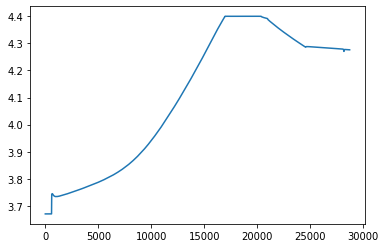

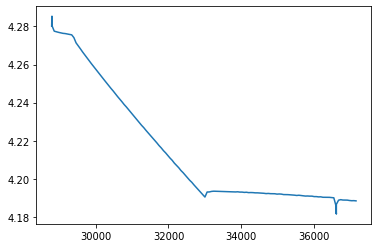

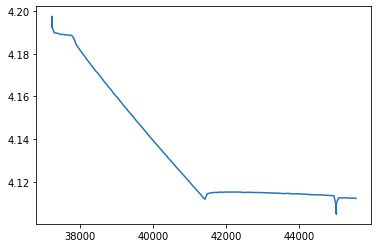

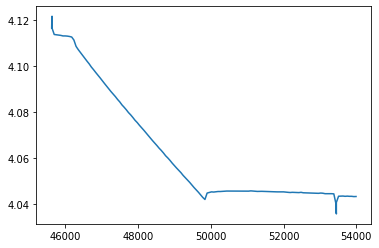

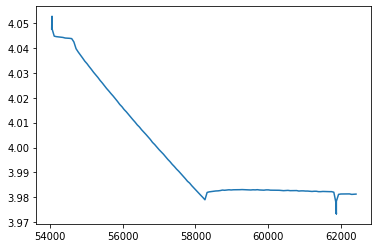

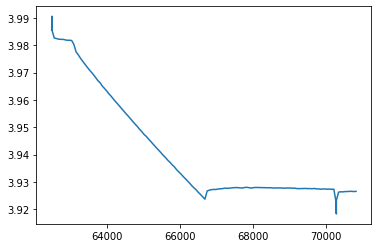

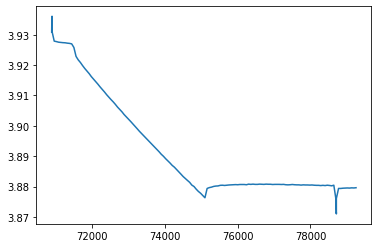

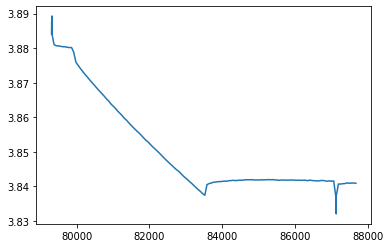

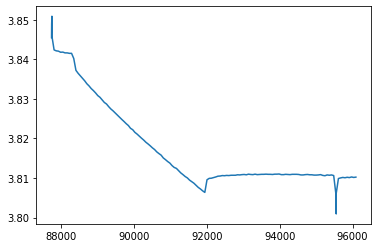

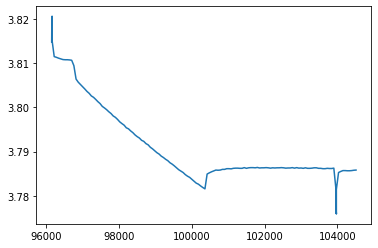

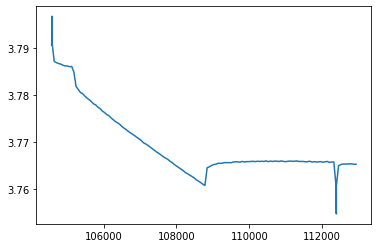

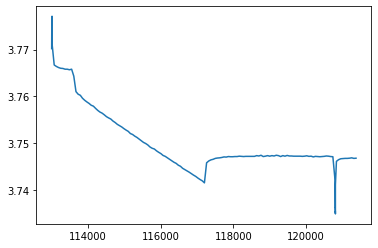

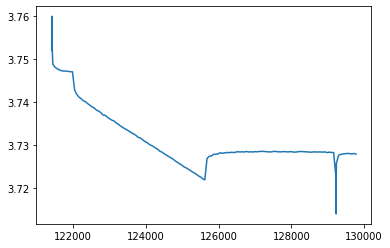

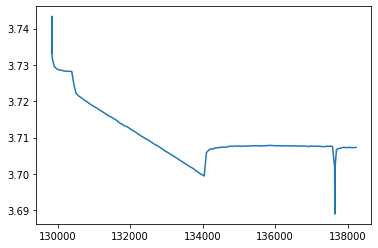

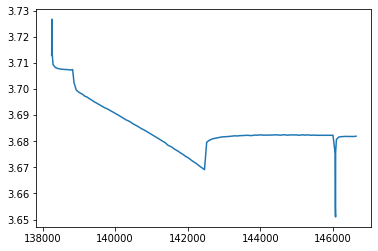

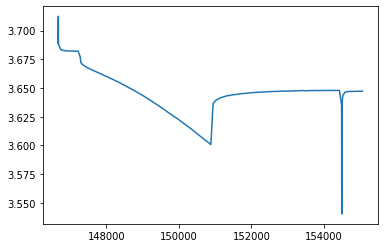

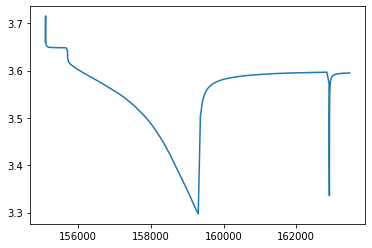

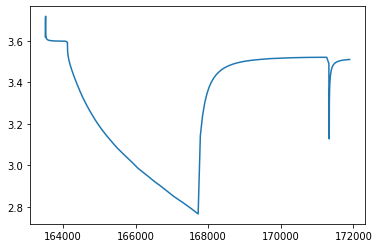

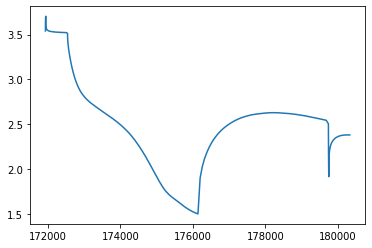

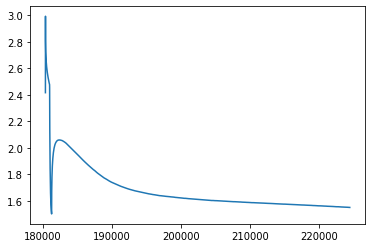

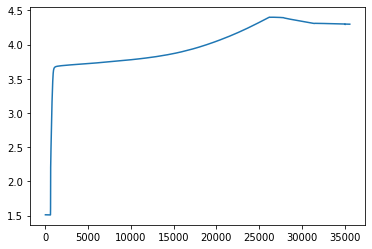

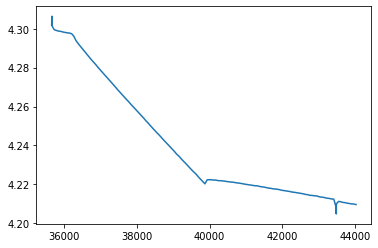

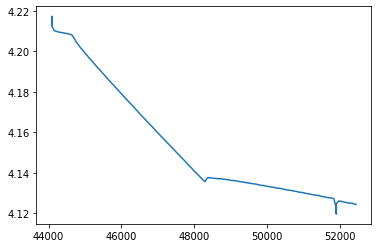

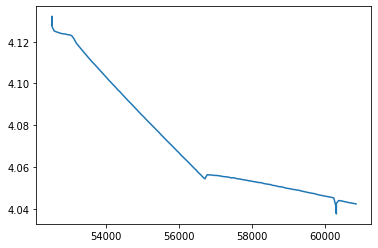

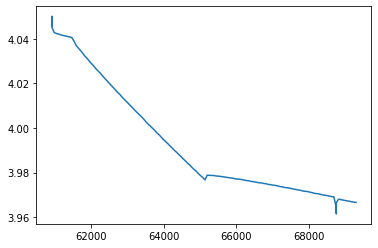

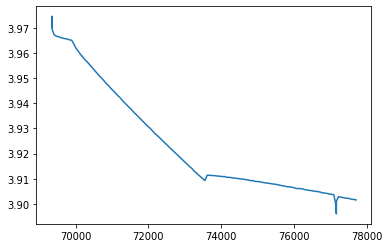

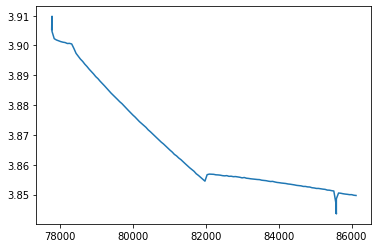

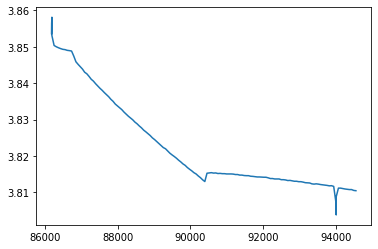

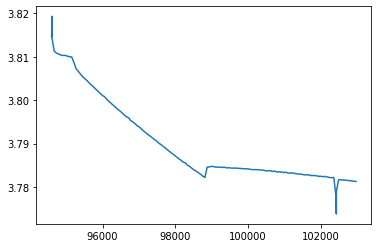

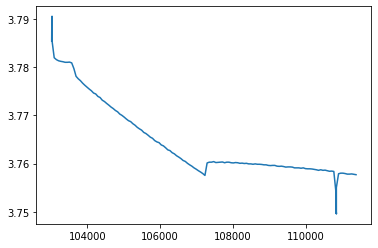

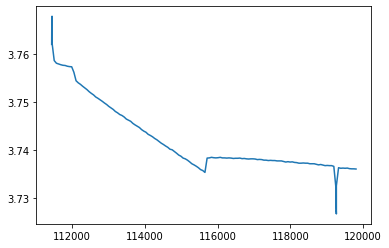

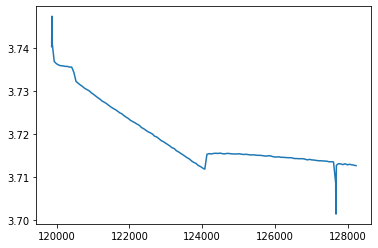

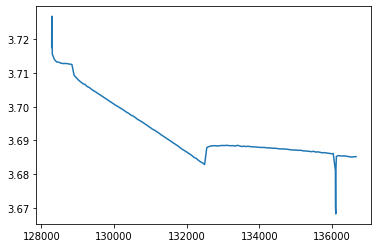

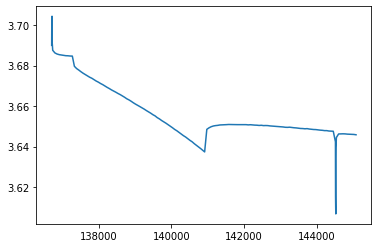

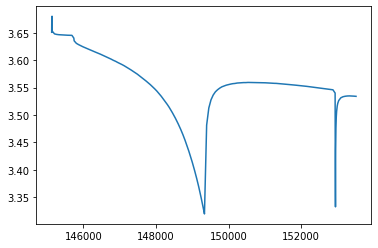

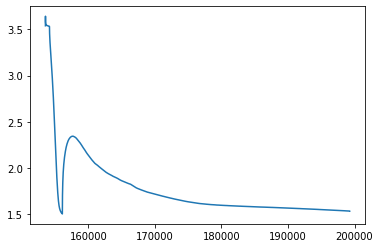

In [30]:
for files in file_paths[0]:
    df = pd.read_csv(files, header=num_header_lines, sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(files, header=num_header_lines-1 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(files, header=num_header_lines-2 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(files, header=num_header_lines-3 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(files, header=num_header_lines-5 , sep='\t', encoding='ISO-8859-1')
    cycles_num=np.unique(df['cycle number'])
    Time=[]
    Voltage=[]
    Current=[]
    for f in cycles_num:
        i=np.where(df['cycle number']==f)
        for d in i[0]:
            Time.append(df['time/s'].iloc[d])
            Voltage.append(df['Ecell/V'].iloc[d])
            
        plt.figure()
        plt.plot(Time,Voltage)
        Time.clear()
        Voltage.clear()


In [3]:
## now my idea is to make a loop that goes through every path and gets all the dataframes to print the graphs
## problem- not all files have same number of rows to skip. Seems to be solved with few if statements for now

In [4]:
def VoltageCurrent(df1, file2):
    cycles_num=np.unique(df1['cycle number'])
    Time=[]
    Voltage=[]
    Current=[]
    for f in cycles_num:
        plt.figure()
        i=np.where(df1['cycle number']==f)
        plt1 =plt.subplot()
        plt2=plt1.twinx()
        Time.append(df1['time/s'].iloc[i]/60)
        Voltage.append(df1['Ecell/V'].iloc[i])
        Current.append(df1['I/mA'].iloc[i])
        plt1.plot(Time[0],Voltage[0], color= 'k')
        plt1.set_xlabel("Time(min)")
        plt1.set_ylabel("Voltage (V)")
        plt2.set_ylabel("Current (mA)")
        plt.title(file2)
        plt2.plot(Time[0],Current[0],color= 'r', ls=':')
        Time.clear()
        Voltage.clear()
        Current.clear()

In [5]:
def Resistance(df1):
    cycles_num=np.unique(df1['cycle number'])
    Time=[]
    Voltage=[]
    Current=[]
    #Resistance=[]
    for a in cycles_num:
        plt.figure()
        i=np.where(df1['cycle number']==a)
        Time.append(abs(df1['time/s'].iloc[i]/60))
        Voltage.append(df1['Ecell/V'].iloc[i])
        Current.append(df1['I/mA'].iloc[i])
        #for k in Current:
         #   if Current[0][k] !=0:
         #       Resistance.append(1000*Voltage[0][k]/Current[0][k])
         #   else:
         #       Resistance.append(0)
        plt.plot(1000*Voltage[0]/Current[0] , Time[0], linewidth=4.0 )
        plt.xlabel('Time(min)')
        plt.ylabel('Resistance($\Omega$)')
        plt.title( str(a) + ' Cycle.')
        Time.clear()
        Voltage.clear()
        Current.clear()
        #Resistance.clear()

In [34]:
def HppcResist(df1):
    cycles_num=np.unique(df1['cycle number'])
    Time=[]
    Voltage=[]
    Current=[]
    SOCxResistance=[]  
    SOC_P=[]
    for k in range(len(df1['time/s'])-2):
        SOC_P.append((df1.loc[k+1,'time/s']-df1.loc[k,'time/s'])*df1.loc[k+1,'I/mA'])
    SOC_T=sum(SOC_P)
    for f in cycles_num:
        i=np.where(df1['cycle number']==f)
        for d in i[0]:
            if df1.loc[d,'I/mA'] < -0.000001 and df1.loc[d,'I/mA'] > -0.2:
                Time.append(df1['time/s'].iloc[d])
                Voltage.append(df1['Ecell/V'].iloc[d])
                Current.append(df1['I/mA'].iloc[d])
                Index_=d
## I checked that my code gets exactly what I need. I get the first and last value of my dataframe and divide by the current
## Question: when we apply negative current the SOC changes so what point to take (first/last)?       
        SOCxResistance.append(sum(SOC_P[:Index_])/SOC_T)
        x=Voltage[-1]
        y=Voltage[0]
        z=Current[0]
        SOCxResistance.append((x-y)/z)
        Time.clear()
        Voltage.clear()
        Current.clear()
    return SOCxResistance
## code cuts dataframe in cycles for each cycle finds where current was applied, Stores current and voltage during 
## these occurences and gives back the array final resistances for each cycle 

    

[-30.011462092165598, 1.0209195387817336, -28.314082229437105, 0.8386419659314825, -26.616765809106084, 0.756154890038415, -24.91958040309539, 0.6953938393314506, -23.222530916240217, 0.6355780472221034, -21.52564837652373, 0.5689333897261911, -19.828824677521627, 0.4966310535940699, -18.1318450970222, 0.4146036883054605, -16.43501903903024, 0.33898147496071307, -14.737811261458763, 0.2795051469331937, -13.040753090090677, 0.24225127875682795, -11.343652603677477, 0.22906230688268894, -9.60361829204298, 0.20912855753989443, -7.897210799418669, 0.250884963581708, -6.138972214417885, 0.33470723406168107, -4.399511258279052, 0.7662967947397805, -2.667391659924085, 3.470098857763722, -0.9397925149251182, 8.287633009307077, 0.7878525145369576, 20.18036709778475, 1.0, 9.699408390524772]
[2.146888709690244, 0.8180028838560969, 2.0683033331064413, 0.7604997435694273, 1.9896839538566462, 0.7135360557934638, 1.9111168807312513, 0.6727059097524659, 1.8325754255017748, 0.6249339855995455, 1.754031

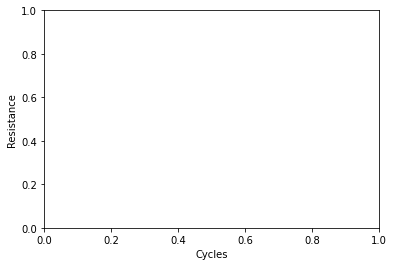

In [35]:
paths = yaml.load(open('../../../paths.yaml', 'r'), Loader=yaml.FullLoader)

DATA_FOLDER = paths['data'] + '2021-08-post-mortem-biologic-pc/'
FILE_GROUP_REGEX_LIST = ['*coin*cell2*hppc*.mpt*']
## sorts every file that has coin and hppc in the folder. datafolder is a path to the folder 
file_paths = [sorted(glob.glob(f'{DATA_FOLDER}{f}')) for f in FILE_GROUP_REGEX_LIST]
plt.figure()
plt.xlabel('Cycles')
plt.ylabel('Resistance')
for files in file_paths[0]:
    k=np.where(file_paths[0]== files)
    num_header_lines = 106

    df = pd.read_csv(files, header=num_header_lines, sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(files, header=num_header_lines-1 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(files, header=num_header_lines-2 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(files, header=num_header_lines-3 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(files, header=num_header_lines-5 , sep='\t', encoding='ISO-8859-1')
    cycles_num=np.unique(df['cycle number'])
    Ohm= HppcResist(df)
    print(Ohm)
#    plt.plot(range(int(Ohm[0])), Ohm[1:-1], label=k, linestyle="",marker="o")
    



In [143]:
for file1 in file_paths[0]:
    num_header_lines = 106
    applied_current = applied_current_ma_vec[0]
    is_cathode = is_cathode_vec[0]
    name = name_vec[0]
    df = pd.read_csv(file1, header=num_header_lines, sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file1, header=num_header_lines-1 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file1, header=num_header_lines-2 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file1, header=num_header_lines-3 , sep='\t', encoding='ISO-8859-1')
    if df.columns[0]!='mode':
        df=pd.read_csv(file1, header=num_header_lines-5 , sep='\t', encoding='ISO-8859-1')
    print(df)
#    VoltageCurrent(df, file1)
#    Resistance(df)

       mode  ox/red  error  control changes  Ns changes  counter inc.  Ns  \
0         3       0      0                0           0             0   0   
1         3       0      0                0           0             0   0   
2         3       0      0                0           0             0   0   
3         3       0      0                0           0             0   0   
4         3       0      0                0           0             0   0   
...     ...     ...    ...              ...         ...           ...  ..   
12433     3       0      0                1           0             1  11   
12434     3       0      0                1           0             1  11   
12435     3       0      0                1           0             1  11   
12436     3       0      0                1           0             1  11   
12437     3       0      0                1           0             1  11   

       I Range         time/s  control/V/mA  ...  Q discharge/mA.h  \
0    